In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation
import numpy as np

# verify if GPU is available
print(tf.test.is_gpu_available())

# set memory growth to true
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Setting memory growth to True for GPU: ", physical_devices[0])
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# dont display much info of tensorflow
tf.get_logger().setLevel('ERROR')


2024-01-21 19:28:51.925574: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-21 19:28:51.999281: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-21 19:28:51.999330: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-21 19:28:52.001639: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-21 19:28:52.014220: I tensorflow/core/platform/cpu_feature_guar

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
Setting memory growth to True for GPU:  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2024-01-21 19:28:54.304193: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-21 19:28:54.350796: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-21 19:28:54.350969: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [2]:
# Load data
manta_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_manta.npy"
xiris_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_xiris.npy"
y_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_y.npy"
feats_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_feats.npy"

# load numpy arrays and display shapes
manta = np.load(manta_path)
#xiris = np.load(xiris_path)
y = np.load(y_path) # only laser power and velocity
print("manta shape: ", manta.shape)

print("y shape: ", y.shape) # laser power and velocity

feats = np.load(feats_path)
print("feats shape: ", feats.shape) # feats shape:  (100, 2, 2, 2, 2, 2, 2, 2, 2, 2)


manta shape:  (9587, 320, 320)
y shape:  (9587, 2)
feats shape:  (9587, 8)


In [3]:
# dimensions of MP are the index 1 and 2 of column in feat

dim_lh = feats[:, 1:3]

max_lh = dim_lh.max(axis=0)

# normalize dim_lh based on max value of each column
dim_lh = dim_lh / max_lh

dim_lh


array([[0.11637931, 0.13836478],
       [0.11206897, 0.1572327 ],
       [0.14224138, 0.13836478],
       ...,
       [0.87068966, 0.47798742],
       [0.87068966, 0.47798742],
       [0.85344828, 0.48427673]])

In [4]:
""" # concatenate manta and xiris images with label y_encoded as rows
# concatenate the two inputs (manta and xiris) along rows
# expand the dimension of x to 4D
manta = np.expand_dims(manta, axis=3)
xiris = np.expand_dims(xiris, axis=3)
x = np.concatenate((manta, xiris), axis=3)
y = dim_lh
print("x shape: ", x.shape)
print("y shape: ", y.shape) """

' # concatenate manta and xiris images with label y_encoded as rows\n# concatenate the two inputs (manta and xiris) along rows\n# expand the dimension of x to 4D\nmanta = np.expand_dims(manta, axis=3)\nxiris = np.expand_dims(xiris, axis=3)\nx = np.concatenate((manta, xiris), axis=3)\ny = dim_lh\nprint("x shape: ", x.shape)\nprint("y shape: ", y.shape) '

In [5]:


# split data into train and test (manta as input and y as output) with shuffle as true
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(manta, dim_lh, test_size=0.2, shuffle=True, random_state=42)
print("x_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)
 

x_train shape:  (7669, 320, 320)
y_train shape:  (7669, 2)
x_test shape:  (1918, 320, 320)
y_test shape:  (1918, 2)


In [6]:
del manta, y, dim_lh, # xiris, x

In [7]:
def build_simpleCNN_model(resolution, n_channels, n_classes):
    """
        Build a simple CNN model with 2 convolutional layers, 2 max pooling layers, 1 fully connected layer and 1 output layer.
        The model is built using the Keras functional API.
        The model is compiled with the Adam optimizer and the categorical cross entropy loss function.
    """
    
    # Define the input shape
    inputs = Input(shape=(resolution, resolution, n_channels))
    x = Conv2D(16, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)

    # Add a fully connected layer with 128 units and a ReLU activation function
    #x = Dense(128, activation='relu')(x)
    #x = Dropout(0.5)(x)
    # Add two output layers each with 1 unit and a linear activation function
    output1 = Dense(n_classes, activation="linear")(x)

    # Define the model with the specified input and outputs
    model = Model(inputs=inputs, outputs=output1)
    return model

In [8]:
# expand the dimension of X_test
X_test = np.expand_dims(X_test, axis=3)
X_train = np.expand_dims(X_train, axis=3)
print("x_test shape: ", X_test.shape)

x_test shape:  (1918, 320, 320, 1)


In [9]:
# build model
resolution = X_test.shape[1]
n_channels = X_test.shape[3]
n_classes = y_test.shape[1]

print("resolution: ", resolution)
print("n_channels: ", n_channels)
print("n_classes: ", n_classes)

# build model
model = build_simpleCNN_model(resolution, n_channels, n_classes)

# compile model
model.compile(optimizer='adam', loss='mse', metrics=['mse'])#, 'mae'])

# print model summary
model.summary()

battch_size = 32
epochs = 20
validation_split = 0.2

# train model
history = model.fit(X_train, y_train,
                    batch_size=battch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=validation_split)


resolution:  320
n_channels:  1
n_classes:  2


2024-01-21 19:29:01.723777: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-21 19:29:01.724148: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-21 19:29:01.724324: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 320, 320, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 318, 318, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 159, 159, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 157, 157, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 78, 78, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 76, 76, 64)        18496 

2024-01-21 19:29:12.815048: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-01-21 19:29:13.010582: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-21 19:29:13.631749: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-21 19:29:14.551486: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fa12e8e8970 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-21 19:29:14.551835: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-01-21 19:29:14.576017: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1705865354.776483 1993527 device_compiler.h:186] 

192/192 [==============================] - 14s 42ms/step - loss: 0.0561 - mse: 0.0561 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 2/20
192/192 [==============================] - 5s 27ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 3/20
192/192 [==============================] - 5s 27ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 4/20
192/192 [==============================] - 5s 26ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 5/20
192/192 [==============================] - 5s 27ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 6/20
192/192 [==============================] - 5s 27ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 7/20
192/192 [==============================] - 5s 26ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 8/20
192/192 [==============================] - 5s 26ms/step - loss: 0.00

In [10]:
# evaluate model
score = model.evaluate(X_test, y_test)
print(score)

60/60 [==============================] - 1s 13ms/step - loss: 0.0012 - mse: 0.0012
[0.001247728825546801, 0.001247728825546801]


60/60 [==============================] - 1s 10ms/step
r2 score:  0.947059602439321


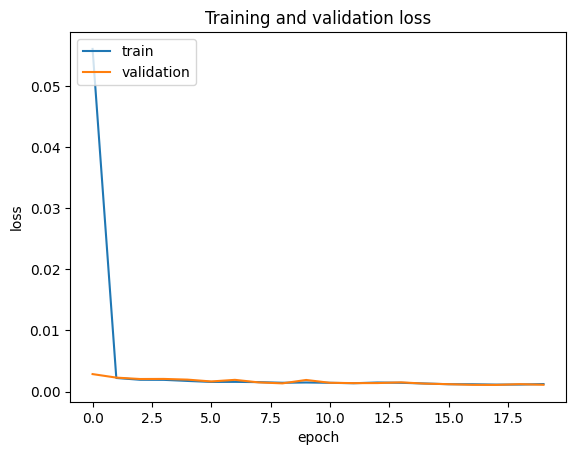

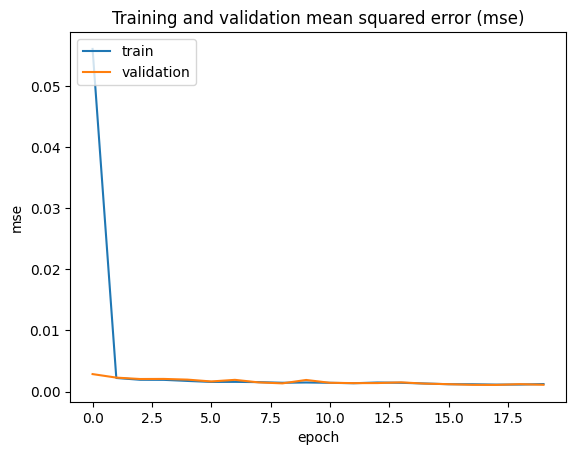

" # plot mse and mae in the same plot\nplt.plot(history.history['mse'])\nplt.plot(history.history['mae'])\nplt.title('Simple CNN model metrics')\nplt.ylabel('metrics')\n\nplt.xlabel('epoch')\nplt.legend(['mse', 'mae'], loc='upper left')\nplt.show() "

In [11]:
# eval regression model
from sklearn.metrics import r2_score

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("r2 score: ", r2)



# plot loss and metrics: mse and mae
import matplotlib.pyplot as plt

# plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation loss')
plt.ylabel('loss')

plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# train and validation mse
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Training and validation mean squared error (mse)')
plt.ylabel('mse')

plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

""" # plot mse and mae in the same plot
plt.plot(history.history['mse'])
plt.plot(history.history['mae'])
plt.title('Simple CNN model metrics')
plt.ylabel('metrics')

plt.xlabel('epoch')
plt.legend(['mse', 'mae'], loc='upper left')
plt.show() """




In [12]:
model.predict(X_test).shape

60/60 [==============================] - 1s 10ms/step


(1918, 2)

In [13]:
y_pred = model.predict(X_test)
r2_l_new = r2_score(y_test[:,0], y_pred[:,0])
r2_h_new = r2_score(y_test[:,1], y_pred[:,1])

print("r2 score: ", r2_l_new, r2_h_new)

60/60 [==============================] - 1s 10ms/step
r2 score:  0.9680324220318032 0.9260867828468393


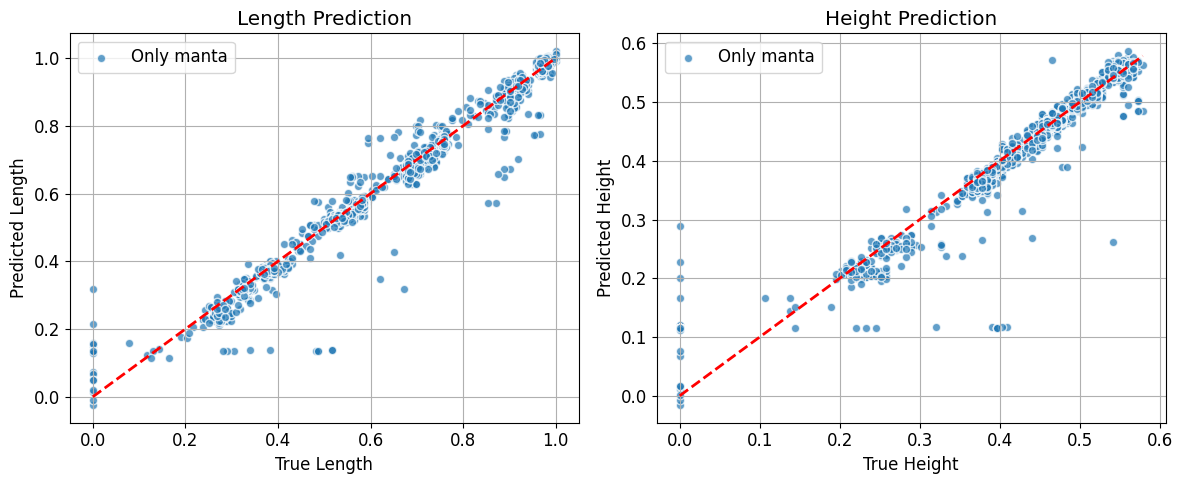

In [14]:
import matplotlib.pyplot as plt

# Increase overall text size
plt.rcParams.update({'font.size': 12})

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plotting the first scatter plot (length prediction)
axs[0].scatter(y_test[:, 0], y_pred[:,0], alpha=0.7, edgecolors='w', label='Only manta')

axs[0].plot([min(y_test[:, 0]), max(y_test[:, 0])], [min(y_test[:, 0]), max(y_test[:, 0])], '--', color='red', linewidth=2)
axs[0].set_title("Length Prediction")
axs[0].set_xlabel("True Length")
axs[0].set_ylabel("Predicted Length")
axs[0].legend()
axs[0].grid(True)

# Plotting the second scatter plot (height prediction)
axs[1].scatter(y_test[:, 1], y_pred[:,1], alpha=0.7, edgecolors='w', label='Only manta')

axs[1].plot([min(y_test[:, 1]), max(y_test[:, 1])], [min(y_test[:, 1]), max(y_test[:, 1])], '--', color='red', linewidth=2)
axs[1].set_title("Height Prediction")
axs[1].set_xlabel("True Height")
axs[1].set_ylabel("Predicted Height")
axs[1].legend()
axs[1].grid(True)

# Adjust layout for better visualization
plt.tight_layout()

# Show the plot
plt.show()



In [15]:
# print layer names
for layer in model.layers:
    print(layer.name)

input_1
conv2d
max_pooling2d
conv2d_1
max_pooling2d_1
conv2d_2
max_pooling2d_2
flatten
dense
dense_1


Layer name: flatten
60/60 [==============================] - 1s 9ms/step


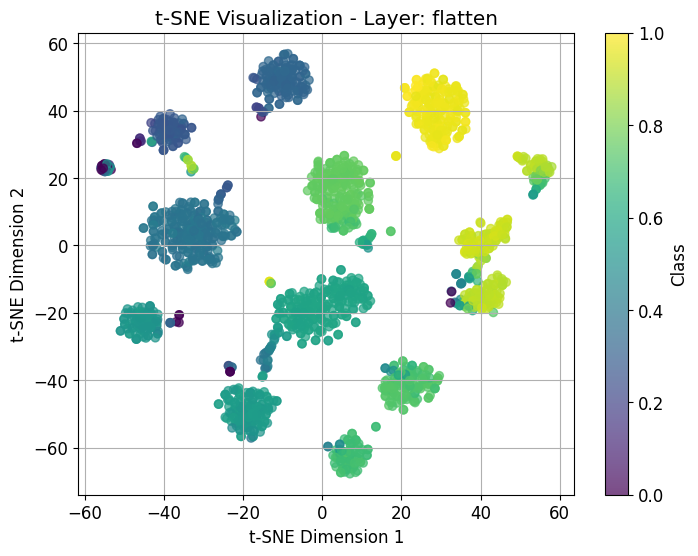

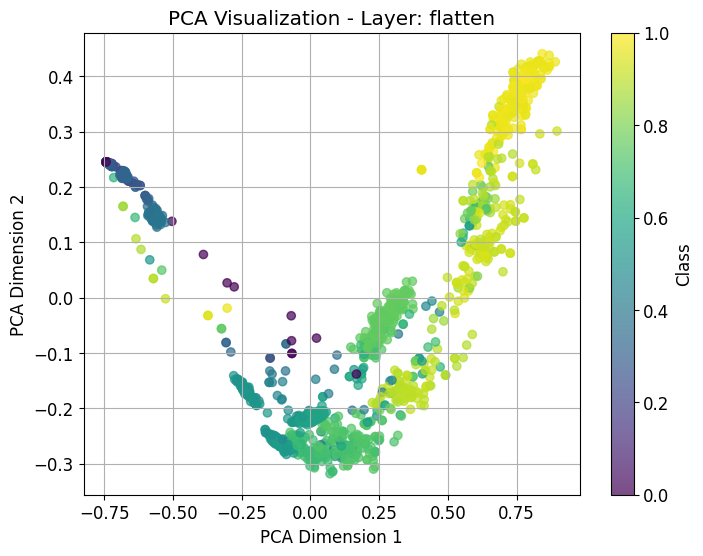

(array([[  4.507655 ,  11.8037405],
        [-14.215262 , -50.142864 ],
        [-25.615086 ,  15.21063  ],
        ...,
        [-42.16788  , -27.377913 ],
        [  6.57984  , -13.587832 ],
        [-10.795357 , -25.731619 ]], dtype=float32),
 array([[ 0.23014404, -0.0748166 ],
        [-0.12041331, -0.26164764],
        [-0.6013711 ,  0.18456118],
        ...,
        [-0.22321264, -0.177626  ],
        [ 0.01379162, -0.21479881],
        [-0.02841914, -0.21540497]], dtype=float32))

In [16]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

N_LAYER = -3

def eval_tsne_pca(model, n_layer, x_test, y_test, plot=True):
    
    # Get intermediate layer output and print the name
    intermediate_layer_model = tf.keras.Model(inputs=model.input, outputs=model.layers[n_layer].output)
    layer_name = model.layers[n_layer].name
    print("Layer name:", layer_name)
    
    intermediate_activations = intermediate_layer_model.predict(x_test)

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(intermediate_activations)

    # Visualize t-SNE results
    if plot:
        plt.figure(figsize=(8, 6))
        plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y_test[:, 0], cmap='viridis', alpha=0.7)
        plt.title(f't-SNE Visualization - Layer: {layer_name}')
        plt.xlabel('t-SNE Dimension 1')
        plt.ylabel('t-SNE Dimension 2')
        plt.colorbar(label='Class')
        plt.grid(True)
        plt.show()

    # Apply PCA
    pca = PCA(n_components=2)
    pca_results = pca.fit_transform(intermediate_activations)

    # Visualize PCA results
    if plot:
        plt.figure(figsize=(8, 6))
        plt.scatter(pca_results[:, 0], pca_results[:, 1], c=y_test[:, 0], cmap='viridis', alpha=0.7)
        plt.title(f'PCA Visualization - Layer: {layer_name}')
        plt.xlabel('PCA Dimension 1')
        plt.ylabel('PCA Dimension 2')
        plt.colorbar(label='Class')
        plt.grid(True)
        plt.show()

    return tsne_results, pca_results

eval_tsne_pca(model, n_layer=N_LAYER, x_test=X_test, y_test=y_test, plot=True)

Layer name: flatten
60/60 [==============================] - 1s 8ms/step


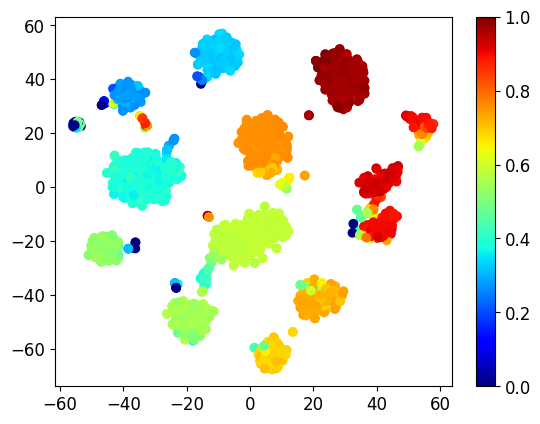

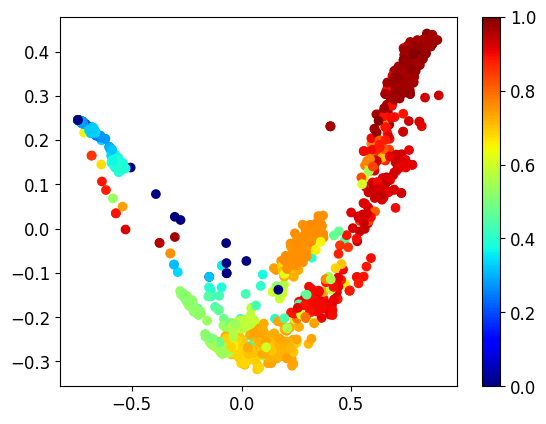

(array([[  4.507655 ,  11.8037405],
        [-14.215262 , -50.142864 ],
        [-25.615086 ,  15.21063  ],
        ...,
        [-42.16788  , -27.377913 ],
        [  6.57984  , -13.587832 ],
        [-10.795357 , -25.731619 ]], dtype=float32),
 array([[ 0.2301476 , -0.07481655],
        [-0.12041315, -0.26164734],
        [-0.6013713 ,  0.18456109],
        ...,
        [-0.22321238, -0.17762603],
        [ 0.01379176, -0.21479876],
        [-0.02841897, -0.21540502]], dtype=float32))

In [17]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

N_LAYER = -3

def eval_tsne_pca(model, n_layer, x_test, y_test, plot=True):
    
    # Get intermediate layer output and print the name
    intermediate_layer_model = tf.keras.Model(inputs=model.input, outputs=model.layers[n_layer].output)
    layer_name = model.layers[n_layer].name
    print("Layer name:", layer_name)
    
    intermediate_activations = intermediate_layer_model.predict(x_test)

    # Apply t-SNE or PCA
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(intermediate_activations)

    # Visualize t-SNE results
    if plot:
        plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y_test[:, 0], cmap='jet')
        plt.colorbar()
        plt.show()

    # apply PCA
    pca = PCA(n_components=2)
    pca_results = pca.fit_transform(intermediate_activations)

    # Visualize PCA results
    if plot:
        plt.scatter(pca_results[:, 0], pca_results[:, 1], c=y_test[:, 0], cmap='jet')
        plt.colorbar()
        plt.show()

    return tsne_results, pca_results

eval_tsne_pca(model, n_layer=N_LAYER, x_test=X_test, y_test=y_test, plot=True)
    

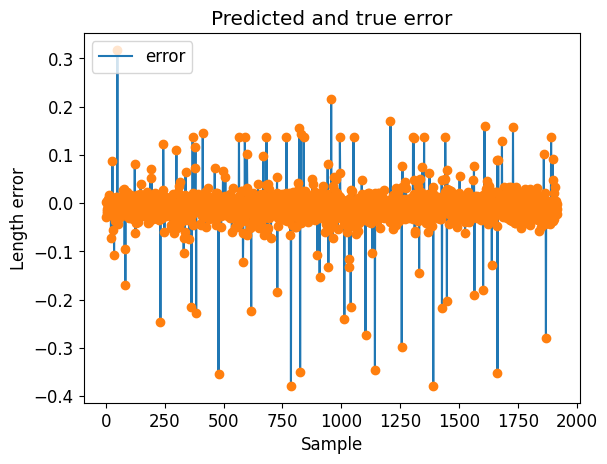

In [18]:
# plot predicted and true error
plt.plot(y_pred[:, 0] - y_test[:, 0])
plt.title('Predicted and true error')
plt.ylabel('Length error')
plt.xlabel('Sample')
plt.legend(['error'], loc='upper left')
# dot not line
plt.plot(y_pred[:, 0] - y_test[:, 0], 'o')
plt.show()
